# Análisis de Sentimientos de Tweets en Español

___Por:___ _Ayar Paco_

___Club de Ciencia de Datos Bolivia___ 

[[facebook: @ccd.bolivia.bo]](https://fb.me/ccd.bolivia.bo) [[Instagram: @ccd.bolivia]](https://www.instagram.com/ccd.bolivia) [[Linkedin: club-de-ciencia-de-datos-bolivia]](https://www.linkedin.com/company/club-de-ciencia-de-datos-bolivia) [[Twitter: @ccdbolivia]](https://twitter.com/ccdbolivia)

## Setup

In [0]:
import numpy as np              # Procesamiento numérico
import pandas as pd             # Manipulación de conjuntos de datos
import matplotlib.pyplot as plt # Gráficos

In [0]:
% pip install tweet-preprocessor   # Instalar librería
import preprocessor as prepro      # Para procesar tweets
import xml.etree.ElementTree as ET # Lectura de archivos XML
from string import punctuation     # Signos de puntuación
import re                          # Op. con exp. regulares

  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7947 sha256=eaea4f373f457a79575082e855631c1ffc57eb3dd9e09ee6e2fa68aeff1ba19f
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor


In [0]:
import nltk                 # Natural language toolkit
nltk.download('stopwords')  # Descargar stopwords
nltk.download('punkt')      # Descargar tokenizador

from nltk.corpus import stopwords # Stopwords
from nltk import word_tokenize    # Tokenizaror
from nltk.stem import SnowballStemmer # Para simplificar palabras

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Lectura de datos

In [0]:
# Lectura
def read_tweets(file_name):
  
  root = ET.parse(file_name).getroot()
  
  tweets = []
  
  for type_tag in root.findall('tweet'):
    content = type_tag.find('content').text
    clean_content = ""
    sentiment =  type_tag.find('sentiment').find('polarity').find('value').text
    tweets.append([content, clean_content, sentiment])
    
  return tweets

In [0]:
tweets = read_tweets('intertass-ES-train-tagged.xml')

In [0]:
# Número de observaciones
len(tweets)

1008

In [0]:
# Ejemplo
tweets[90]

['@SirDeschain @ChicaCascabel @reptarazul más bien tas tenía aprecio por raistlin, yo creo que al mago le daba un poco igual todo ',
 '',
 'N']

## Limpieza de datos

In [0]:
# Signos de puntuación a remover
non_words = punctuation+str('¿¡“”')
non_words

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¿¡“”'

In [0]:
# Limpar oraciones
def clean_sentence(tweet):
  
    # Stop words (Set: Conjunto desordenado de elementos únicos)
    stop_words = set(stopwords.words('spanish')) 
    
    # Stemmer (Simplifica palabras quitándoles prefijos o sufijos)
    stemmer = SnowballStemmer('spanish')
   
    # Quitar números
    tweet = re.sub(r'[0-9]+', '', tweet)
    
    # Quitar signos de puntuacion
    tweet = re.sub('[%s]' % re.escape(non_words), ' ', tweet)
    
    # Eliminar letras repetidas
    tweet =re.sub(r'([aeiou])\1+', r'\1',tweet)
    
    # Tokenizar (Separar cadena en palabras y signos de puntuación)
    word_tokens = word_tokenize(tweet)
      
    filtered_tweet=[]
    stemmed_tweet=[]
    
    for w in word_tokens:
      
        if w not in stop_words and w not in list(non_words):
            
            # Tweet limpio v1 (Para análisis previo)
            filtered_tweet.append(w.lower())
            
            # Tweet límpio v2 (Para entrenamiento de modelos)
            stemmed_tweet.append(stemmer.stem(w))
    
    return [' '.join(filtered_tweet), ' '.join(stemmed_tweet)]

In [0]:
# Ordenar tweets aleatoriamente
n_tweets = np.array(range(len(tweets)))
np.random.shuffle(n_tweets)

In [0]:
# Pruebas
for i in range(3):
  num_tweet = n_tweets[i]
  print(">> tweet nº"+str(num_tweet))
  print("- Original: \n")
  print("\t" + tweets[num_tweet][0])
  print("")
  print("- Tweet limpio: \n") 
  print("\t" + prepro.clean(tweets[num_tweet][0]))
  print("")
  print("- Sin stopwords ni puntuación: \n")
  print("\t" + clean_sentence(prepro.clean(tweets[num_tweet][0]))[0])
  print("")
  print("- Steemed: \n")
  print("\t" + clean_sentence(prepro.clean(tweets[num_tweet][0]))[1])
  print("-------------------------------------------------------------------------")

>> tweet nº183
- Original: 

	Mi puto novio me ignora y quiero saber si hay un chino cerca de la biblioteca 

- Tweet limpio: 

	Mi puto novio me ignora y quiero saber si hay un chino cerca de la biblioteca

- Sin stopwords ni puntuación: 

	mi puto novio ignora quiero saber si chino cerca biblioteca

- Steemed: 

	mi put novi ignor quier sab si chin cerc bibliotec
-------------------------------------------------------------------------
>> tweet nº568
- Original: 

	@keirzar yo lo tengo facil  mi unicovy verdadero amor es pokemon 

- Tweet limpio: 

	yo lo tengo facil mi unicovy verdadero amor es pokemon

- Sin stopwords ni puntuación: 

	facil unicovy verdadero amor pokemon

- Steemed: 

	facil unicovy verdader amor pokemon
-------------------------------------------------------------------------
>> tweet nº145
- Original: 

	Estoy muy nerviosa por el partido 

- Tweet limpio: 

	Estoy muy nerviosa por el partido

- Sin stopwords ni puntuación: 

	estoy nerviosa partido

- Steemed: 


In [0]:
# Limpiar tweets y guardarlos en nuestra lista
for t in tweets:
  t[1] = clean_sentence(prepro.clean(t[0]))

In [0]:
# Ejemplo
tweets[1]

['@myendlesshazza a. que puto mal escribo\n\nb. me sigo surrando help \n\n3. ha quedado raro el "cómetelo" ahí JAJAJAJA',
 ['puto mal escribo b sigo surrando help quedado raro cómetelo ahí jajajaja',
  'put mal escrib b sig surr help qued rar cometel ahi jajajaj'],
 'N']

## Generar conjunto de datos

In [0]:
# Generador de datos de modelación en bruto
def gen_raw_modeling_dataset(tweets):
  
  X_v1 = [] 
  X_v2 = [] 
  y = []
  
  for t in tweets:
    X_v1.append(t[1][0])
    X_v2.append(t[1][1])
    y.append(t[2])
    
  X_v1 = np.array(X_v1)
  X_v2 = np.array(X_v2)
  y = np.array(y)
  
  return X_v1, X_v2, y

In [0]:
X_v1, X_v2, y = gen_raw_modeling_dataset(tweets)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer # Vectorizador de textos

In [0]:
# Vectorizar tweets
vectorizer_v1 = CountVectorizer()
vectorizer_v2 = CountVectorizer()
  
X_v1 = vectorizer_v1.fit_transform(X_v1)
X_v2 = vectorizer_v2.fit_transform(X_v2)

## Análisis previo

### Frecuencia de palabras

In [0]:
# Palabras y frecuencias
words_v1 = vectorizer_v1.get_feature_names()
counts_v1 = np.sum(X_v1.toarray(),0)

words_v2 = vectorizer_v2.get_feature_names()
counts_v2 = np.sum(X_v2.toarray(),0)

In [0]:
# Palabras de Tweets limpios v1
words_data_v1 = pd.DataFrame(np.column_stack([words_v1,counts_v1]))
words_data_v1.columns = ["words","counts"]
words_data_v1.head(5)

,words,counts
0,abajo,1
1,abandonado,2
2,abandone,1
3,abandoné,1
4,abatido,1


In [0]:
# Palabras de Tweets limpios v2
words_data_v2 = pd.DataFrame(np.column_stack([words_v2,counts_v2]))
words_data_v2.columns = ["words","counts"]
words_data_v2.head(5)

,words,counts
0,abac,1
1,abaj,1
2,abandon,4
3,abat,1
4,abces,1


In [0]:
# Veamos los tipos de variables
words_data_v1.dtypes

words     object
counts    object
dtype: object

In [0]:
# Ajustemos
words_data_v1 = words_data_v1.apply(pd.to_numeric, errors='ignore')
words_data_v1.dtypes

words     object
counts     int64
dtype: object

In [0]:
# Frecuencias ordenadas
words_data_v1.sort_values("counts", ascending = False).head(20)

,words,counts
3192,si,82
1512,gracias,54
2111,me,48
2340,no,46
1663,hoy,41
1067,día,38
2908,quiero,37
3596,ver,35
3261,solo,35
2851,pues,34


### Nube de palabras

In [0]:
from wordcloud import WordCloud # Para crear una nube de palabras

In [0]:
# Generar diccionario con frecuencias
dict_v1 = {}
for word, frec in words_data_v1.values:
    dict_v1[word] = frec

In [0]:
# Nube de palabras
wordcloud = WordCloud(width = 1500, height = 800,
                      background_color ='white', 
                      min_font_size = 12)

wordcloud.generate_from_frequencies(frequencies=dict_v1)

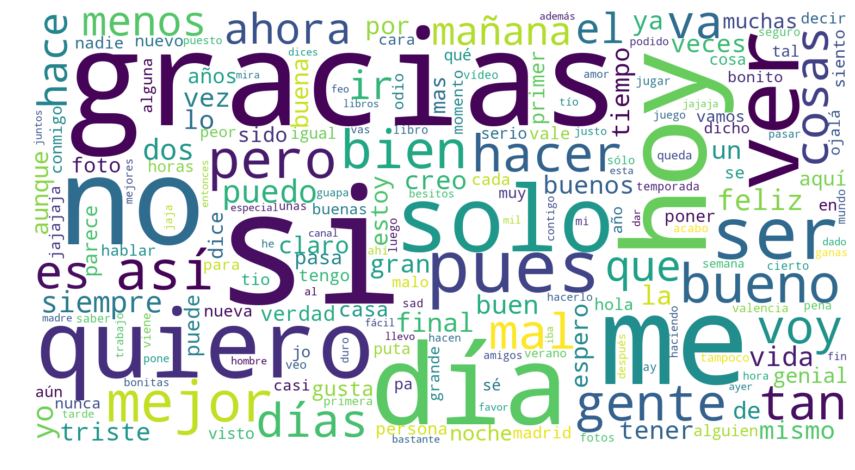

In [0]:
plt.figure(figsize = (15, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Frecuencia de sentimientos

In [0]:
# Convertir vector de sentimientos a DataFrame
y_data = pd.DataFrame(y)
y_data.columns = ["sentiment"]

In [0]:
# Frecuencia de sentimientos
y_data.sentiment.value_counts()/y_data.shape[0]

N       0.414683
P       0.315476
NONE    0.137897
NEU     0.131944
Name: sentiment, dtype: float64

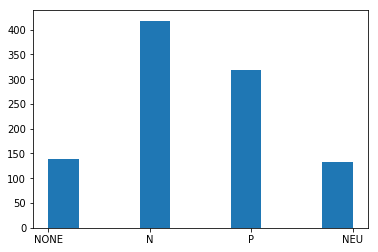

In [0]:
# Graficar
plt.hist(y)
plt.show()

In [0]:
for t in np.arange(len(y_data))[y_data.sentiment=="NEU"][1:10]:
  print(tweets[t])

['@KunMadera pues date unas cuantas horas, que es muy temprano ', ['pues date unas cuantas horas temprano', 'pues dat unas cuant hor tempran'], 'NEU']
['Solo porque UNA persona diga que me conoce y opine sobre cómo soy, y convenza a otra de ello no significa que sea así ', ['solo una persona diga conoce opine cómo convenza ello significa así', 'sol una person dig conoc opin com convenz ello signif asi'], 'NEU']
["comprendo que te molen mis tattoos, pero no te los hagas 'iguales' ", ['comprendo molen tattos hagas iguales', 'comprend mol tatt hag igual'], 'NEU']
['@IvnLz el resto puedo dudar pero de ese grupo lo tengo claro ', ['resto puedo dudar grupo claro', 'rest pued dud grup clar'], 'NEU']
['@Adriansoler espero y deseo que el interior te cause lo mismo ', ['espero deseo interior cause mismo', 'esper dese interior caus mism'], 'NEU']
['Es worth para coger el bonus, pero es mucho más divertido luchar ', ['es worth coger bonus divertido luchar', 'es worth cog bonus divert luch'], 'NEU'

## Modelación

### Datos de modelación

In [0]:
# Filtrar sentimiesntos positivos y negativos
ix = np.isin(y, ["N","P"])
ix

array([False,  True,  True, ..., False,  True,  True])

In [0]:
X_v2_f = X_v2[np.arange(len(y))[ix],:]
y_f = y[ix]

In [0]:
# Separar datos de entrenamiento y testeo
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_v2_f, y_f,
                                                    test_size=0.2,
                                                    random_state=42)

### Entrenamiento y testeo

#### Random Forest

In [0]:
# Importar
from sklearn.ensemble import RandomForestClassifier

In [0]:
# Definición del bosque aleatorio
clas_rf = RandomForestClassifier(n_estimators=10000,
                                 min_samples_leaf = 2,
                                 class_weight = "balanced") 

# Entrenamiento del bosque
clas_rf = clas_rf.fit(X_train, Y_train)

__Evaluacion en conjunto de entrenamiento__

In [0]:
# Matriz de confusión
rf_mc_train = pd.crosstab(clas_rf.predict(X_train),Y_train)
rf_mc_train

col_0,N,P
row_0,,
N,300,27
P,26,235


In [0]:
# Tasas de predicción
(rf_mc_train/np.sum(rf_mc_train,0)).round(4)

col_0,N,P
row_0,,
N,0.9202,0.1031
P,0.0798,0.8969


__Evaluacion en conjunto de testeo__

In [0]:
# Matrices de confusión
rf_mc_test = pd.crosstab(clas_rf.predict(X_test),Y_test)
rf_mc_test

col_0,N,P
row_0,,
N,71,22
P,21,34


In [0]:
# Tasas de predicción
(rf_mc_test/np.sum(rf_mc_test,0)).round(4)

col_0,N,P
row_0,,
N,0.7717,0.3929
P,0.2283,0.6071


#### Support Vector Machine

In [0]:
# Importar libreria
from sklearn import svm

In [0]:
# Definición del modelo
svm_model = svm.SVC(C=0.01, kernel='rbf')

# Entrenamiento
svm_model.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

__Evaluacion en conjunto de entrenamiento__

In [0]:
# Matriz de confusión
svm_mc_train = pd.crosstab(svm_model.predict(X_train), Y_train)
svm_mc_train

col_0,N,P
row_0,,
N,326,262


__Evaluacion en conjunto de testeo__

In [0]:
# Matriz de confusión
svm_mc_test = pd.crosstab(svm_model.predict(X_test), Y_test)
svm_mc_test

col_0,N,P
row_0,,
N,92,56


#### Red neuronal

In [0]:
X_train.shape

(588, 2650)

In [0]:
# Importar librerias de keras
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
# Definir modelo
rn_keras_sec = Sequential()
rn_keras_sec.add(
    Dense(100,input_dim=2650,activation='relu',
          activity_regularizer = regularizers.l2(l=0.01)))  # Primera capa oculta
rn_keras_sec.add(Dropout(rate = 0.5))                       # Dropout
rn_keras_sec.add(Dense(100,activation='relu'))              # Segunda capa oculta
rn_keras_sec.add(Dense(1,activation='softmax'))             # Capa de salida





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Ver arquitectura
rn_keras_sec.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               265100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 275,301
Trainable params: 275,301
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compilar modelo
adam = optimizers.Adam(lr=0.1)
rn_keras_sec.compile(loss='binary_crossentropy',
                     optimizer=adam,
                     metrics=['binary_accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
Y_train_aux = (Y_train == "P")   # True -> P

In [0]:
# Entrenar modelo
rn_keras_sec_fit = rn_keras_sec.fit(X_train, Y_train_aux, nb_epoch=100, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/100
 - 1s - loss: 8.8436 - binary_accuracy: 0.4456
Epoch 2/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 3/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 4/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 5/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 6/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 7/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 8/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 9/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 10/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 11/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 12/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 13/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 14/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 15/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 16/100
 - 0s - loss: 8.8388 - binary_accuracy: 0.4456
Epoch 17/100
 - 0s - loss: 8.8388 - binary_accura

__Evaluación en conjunto de entrenamiento__

In [0]:
Y_hat_train_rn = rn_keras_sec.predict(X_train)

In [0]:
Y_hat_train_rn.shape

(588, 1)

In [0]:
pd.crosstab(np.ravel(Y_hat_train_rn)==1,Y_train_aux)

col_0,False,True
row_0,,
True,326,262


__Evaluación en conjunto de testeo__

In [0]:
Y_hat_test_rn = rn_keras_sec.predict(X_test)

In [0]:
Y_test_aux = (Y_test == "P")

In [0]:
pd.crosstab(np.ravel(Y_hat_test_rn)==1,Y_test_aux)

col_0,False,True
row_0,,
True,92,56


## Analisis de nuevos tweets

### Lectura desde twiter

Se debe crear una cuenta de desarroollador en twitter:

https://developer.twitter.com/content/developer-twitter/en.html

In [0]:
import tweepy as tw             # Para extraer tweets

In [0]:
# Definir claves de acceso a la API
consumer_key= 
consumer_secret= 
access_token= 
access_token_secret= 

In [0]:
# Autentificarse e iniciar API
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [0]:
# Extraer tweets por palabra clave
def get_tweets_by_words(keyword, date_since, geo, n):
    
    tweets_list = []
    
    # Buscar tweets
    for tweet in tw.Cursor(api.search,
                           q=keyword,
                           lang="es",
                           since=date_since,
                           geocode = geo,
                           tweet_mode="extended").items(n):
      
      if True: #tweet.coordinates is not None:
        
        # Add tweets in this format
        dict_ = {'Screen Name': tweet.user.screen_name,
                 'User Name': tweet.user.name,
                 'Tweet Created At': str(tweet.created_at),
                 'Tweet Text': tweet.full_text,
                 'User Location': str(tweet.user.location),
                 'Tweet Coordinates': str(tweet.coordinates),
                 'Retweet Count': str(tweet.retweet_count),
                 'Retweeted': str(tweet.retweeted),
                 'Phone Type': str(tweet.source),
                 'Favorite Count': str(tweet.favorite_count),
                 'Favorited': str(tweet.favorited),
                 'Replied': str(tweet.in_reply_to_status_id_str)
                 }
        tweets_list.append(dict_)   
    
    return tweets_list

In [0]:
  # Extraer tweets por usuario
  def get_tweets_by_user(user_tag, date_since, n):
      
      listOfTweets = []
      
      # Buscar tweets
      for tweet in tw.Cursor(api.user_timeline, 
                             screen_name=user_tag, 
                             lang="es",
                             since=date_since,
                             tweet_mode="extended").items(n):
        
        if True: #tweet.coordinates is not None:
          
          # Add tweets in this format
          dict_ = {'Screen Name': tweet.user.screen_name,
                  'User Name': tweet.user.name,
                  'Tweet Created At': str(tweet.created_at),
                  'Tweet Text': tweet.full_text,
                  'User Location': str(tweet.user.location),
                  'Tweet Coordinates': str(tweet.coordinates),
                  'Retweet Count': str(tweet.retweet_count),
                  'Retweeted': str(tweet.retweeted),
                  'Phone Type': str(tweet.source),
                  'Favorite Count': str(tweet.favorite_count),
                  'Favorited': str(tweet.favorited),
                  'Replied': str(tweet.in_reply_to_status_id_str)
                  }
          listOfTweets.append(dict_)
          
      return listOfTweets

In [0]:
# Busqueda por palabra
search_words = "Bolivia"
search_words = search_words + " -filter:retweets"
date_since = "2019-01-01"
geo = "-17.387511,-66.141562,300km"

bolivian_tweets_raw = get_tweets_by_words(search_words, date_since, geo, 1000)

In [0]:
# Busqueda por usuario
user = "@evoespueblo"
date_since = "2010-01-01"

bolivian_tweets_raw = get_tweets_by_user(user_tag = user,
                                         date_since = date_since,
                                         n = 1000)

In [0]:
# Contar número de tweets extraidos
len(bolivian_tweets_raw)

1000

In [0]:
# Ver ejemplarers
bolivian_tweets_raw[1:5]

[{'Favorite Count': '0',
  'Favorited': 'False',
  'Phone Type': 'Twitter for Android',
  'Replied': '1172653778018942976',
  'Retweet Count': '0',
  'Retweeted': 'False',
  'Screen Name': 'PabloArceVieira',
  'Tweet Coordinates': 'None',
  'Tweet Created At': '2019-09-14 20:30:08',
  'Tweet Text': '@marenos24175207 @renepereiras @TaniaLo98001824 @Ruth977254491 @JohnnyBamb @AlbertoRealname @Denniss93214338 @ElvinAngelLina3 @MarcoRamosCruz1 @PrincipeEber @vanchi_tavera @lagentedellago @bevirage @NoFear21F @tritigrehernan @Carito13440640 @Alejand07215192 @csoria_eid @lobonoche @PabloEid @bitduart @Chari61439076 @Espantobreve @mendezdecadario @llamerosolo @JulioOrellana @SResista @Shei_sm7 @aeoblitaspaz @jptipnis @ciudadan0libre @jaredxbcx @vj007tr @Virgili99138815 @fredarpo @therinsomnia @dindi888 @CAZADORDECORRU4 @johnramos28 @DitoZambrana @YAJATENONDE @accesoriosroma2 @OroDeLey @josealvarado75 @FVidango @Gaelito08594974 @OrejaPulga @MarquinhoR87 @khato_tkatari @NicolasMaduro Lo más rid

### Limpieza de datos

In [0]:
# Limpiar tweets y guardarlos en una lista
bolivian_tweets = []

for t in bolivian_tweets_raw:
  original_tweet = t['Tweet Text']
  bolivian_tweets.append([original_tweet,
                          clean_sentence(prepro.clean(original_tweet))
                         ])

In [0]:
# Ver ejemplos
bolivian_tweets[1:5]

[['@marenos24175207 @renepereiras @TaniaLo98001824 @Ruth977254491 @JohnnyBamb @AlbertoRealname @Denniss93214338 @ElvinAngelLina3 @MarcoRamosCruz1 @PrincipeEber @vanchi_tavera @lagentedellago @bevirage @NoFear21F @tritigrehernan @Carito13440640 @Alejand07215192 @csoria_eid @lobonoche @PabloEid @bitduart @Chari61439076 @Espantobreve @mendezdecadario @llamerosolo @JulioOrellana @SResista @Shei_sm7 @aeoblitaspaz @jptipnis @ciudadan0libre @jaredxbcx @vj007tr @Virgili99138815 @fredarpo @therinsomnia @dindi888 @CAZADORDECORRU4 @johnramos28 @DitoZambrana @YAJATENONDE @accesoriosroma2 @OroDeLey @josealvarado75 @FVidango @Gaelito08594974 @OrejaPulga @MarquinhoR87 @khato_tkatari @NicolasMaduro Lo más ridículo que puedes hacer es creer tu estupidez, no sabes nada de economía.\nBolivia seguirá creciendo a pesar de tu mala interpretación, es en vano enseñarte querido Walter.\nES INVERSIÓN \nNO ES GASTO PÚBLICO \nANIMAL....\nPARECE DÉFICIT PORQUE SON DINEROS PRESTADOS.',
  ['lo ridículo puedes hacer 

In [0]:
# Generar conjuntos de datos vectorizados
X_newb_v1 = []
  
for t in bolivian_tweets:
  X_newb_v1.append(t[1][0])
    
X_newb_v1 = np.array(X_newb_v1)
vec_newb_v1 = CountVectorizer()
  
X_newb_v1 = vec_newb_v1.fit_transform(X_newb_v1)

### Frecuencia de palabras

In [0]:
# Palabras y frecuencias
words_newb_v1 = vec_newb_v1.get_feature_names()
counts_newb_v1 = np.sum(X_newb_v1.toarray(),0)

In [0]:
# Palabras de Tweets limpios v1
words_dnew_v1 = pd.DataFrame(np.column_stack([words_newb_v1,counts_newb_v1]))
words_dnew_v1.columns = ["words","counts"]
words_dnew_v1.head(5)

,words,counts
0,abandonadas,1
1,abandonado,1
2,abandonados,1
3,abandonará,1
4,abandonemos,1


In [0]:
# Ajustemos los tipos de variables
words_dnew_v1 = words_dnew_v1.apply(pd.to_numeric, errors='ignore')

In [0]:
words_dnew_v1.dtypes

words     object
counts     int64
dtype: object

In [0]:
# Frecuencias ordenadas
words_dnew_v1.sort_values("counts", ascending = False).head(20)

,words,counts
484,bolivia,400
1492,el,132
2464,la,120
1060,cruz,84
3844,santa,84
1753,evo,59
2932,no,50
2004,gobierno,48
4436,violencia,44
3903,septiembre,43


### Nube de valabras

In [0]:
# Diccionario con frecuencias
dict_newb_v1 = {}
for word, frec in words_dnew_v1.values:
    dict_newb_v1[word] = frec

In [0]:
# Nube de palabras
wordcloud_new = WordCloud(width = 1500, height = 800,
                      background_color ='white', 
                      min_font_size = 12)
wordcloud_new.generate_from_frequencies(frequencies=dict_newb_v1)

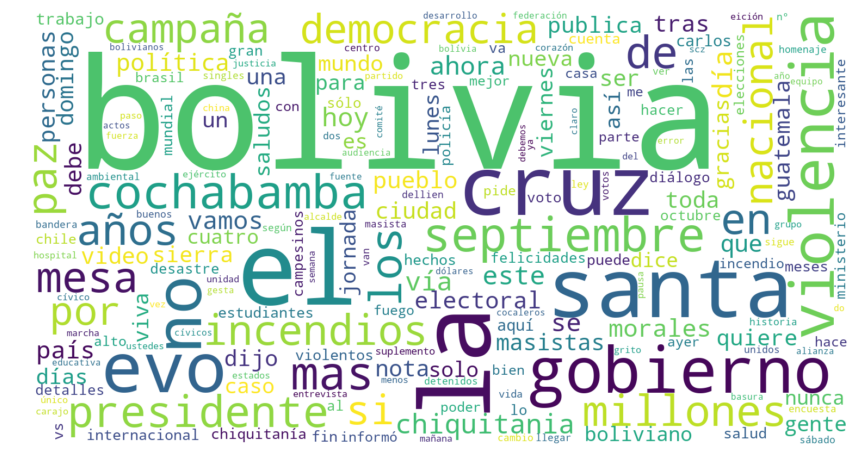

In [0]:
plt.figure(figsize = (15, 8), facecolor = None)
plt.imshow(wordcloud_new, interpolation="bilinear")
plt.axis("off")
plt.show()

### Predicción de sentimientos

In [0]:
# Vocabulario del modelo
model_vocabulary = vectorizer_v2.get_feature_names()
model_vocabulary[1:10]

['abaj',
 'abandon',
 'abat',
 'abces',
 'abiert',
 'abraz',
 'abrazar',
 'abrazart',
 'abrazot']

In [0]:
# Listar tweets limpios
bolivian_tweets_v2 = []

for t in bolivian_tweets:
  bolivian_tweets_v2.append(t[1][1])

In [0]:
# Extraer los atributos modelación presentes en los nuevos tweets
def extract_features_data(tweets, vocabulary):
  
  data = []
  
  for tweet in tweets:
    
    tweet_words = tweet.split()
    features = []
    
    for word in vocabulary:
      
      if word in tweet_words:
        features.append((tweet_words.count(word)))
      else:
        features.append((0))
        
    data.append(np.array(features))
  
  return np.array(data)

In [0]:
b_tweet_data = extract_features_data(bolivian_tweets_v2, model_vocabulary)
b_tweet_data.shape

(1000, 2650)

In [0]:
# Estimar sentimientos de los nuevos tweets
sentiments_b_tweets = clas_rf.predict(b_tweet_data)

#### Frecuencias de sentimientos estimados

In [0]:
# Convertir vector de sentimientos a DataFrame
sentiments_b_tweets_d = pd.DataFrame(sentiments_b_tweets)
sentiments_b_tweets_d.columns = ["sentiment"]

In [0]:
# Frecuencia de sentimientos
sentiments_b_tweets_d.sentiment.value_counts()/sentiments_b_tweets_d.shape[0]

P    0.565
N    0.435
Name: sentiment, dtype: float64

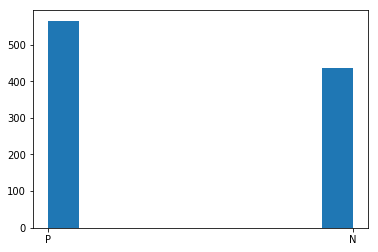

In [0]:
# Graficar
plt.hist(sentiments_b_tweets)
plt.show()

## Conclusiones

* Es posible estimar sentimientos de tweets en español con resultados medianamente aceptables con un conjunto de datos pequeño y sin necesidad de emplear modelos complejos.
* La mayoria de los tweets en nuestro entorno no tienen una geolocalización exacta y esto restringe la posibilidad de realizar análisis que incluyan el espacio.
* El procesamiento de lenguaje en el idioma español por ahora no es muy conocido o divulgado y por ello no hay un estandar de análisis fácilmente identifable.

## Recomendaciones

* Replicar el análisis usando conjuntos de datos más grandes.
* Identificar hiperparámetros óptimos para el modelo seleccionado.
* Proponer mecanismos para construir conjuntos de datos aprovechando la actual facilidad de acceso a tweets.
* Replicar el análisis usando representaciones vectorizadas de las palabras. (Word embeding)

## Líneas de investigación

* Demostrar teóricamente el motivo por el cual las redes neuronales y las máquinas de vectores de soporte no lograron superar a los bosques aleatorios.
* Proponer alternativas para realizar análisis de sentimientos que consideren el uso de emoticones.
* Evaluar cambio marginal en rendimiento de los modelos al usar representaciones vectorizadas de las palabras.
* Realizar estimaciones de sentimientos de tweets de los principales medios de comunicación en el pais.
* Realizar un monitoreo de estimaciones de sentimientos de tweets con palabras claves respecto a las elecciones nacionales durante el periodo de campaña de los candidatos.